# Relax Data  Science Challenge

The descriptions of this challenge and datasets are in the pdf file, which also contains the description of each column. 

In [61]:
import pandas as pd
from collections import defaultdict
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df_users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [58]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [7]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [8]:
df_engage = pd.read_csv('takehome_user_engagement.csv')

In [24]:
df_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [28]:
# Are they sorted by user_id and then by time?
df_engage.sort_values(['user_id','time_stamp']).equals(df_engage)

True

The dataset is sorted by user_id and then by time! This fact will be useful when I find adopted users in O(n) time later.

In [10]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
df_engage.time_stamp = pd.to_datetime(df_engage.time_stamp)

In [19]:
df_engage.time_stamp.min(), df_engage.time_stamp.max()

(Timestamp('2012-05-31 08:20:06'), Timestamp('2014-06-06 14:58:50'))

### Adopted users

Find adopted users, users who have logged into the product on three separate days in at least one 7-day period

In [20]:
df_engage.user_id.nunique() # number of users

8823

In [17]:
df_engage.time_stamp.max()-df_engage.time_stamp.min() # number of days

Timedelta('736 days 06:38:44')

There are about 737 possible days.

In [46]:
# Find adapted users using O(n) time complexity
engage_dic = defaultdict(list)
adopt_users = set()
for user, time in df_engage[['user_id','time_stamp']].values:
    if user not in adopt_users:
        if len(engage_dic[user])<2:
            engage_dic[user].append(time)
        else: #len(engage_dic[user])==2
            if time < engage_dic[user][0] + timedelta(days=7):
                adopt_users.add(user)
            else:
                engage_dic[user].append(time)
                engage_dic[user].pop(0)

In [48]:
len(adopt_users)

1602

There are 1602 adopted users.

In [52]:
# Make the target column representing adoption
df_users['adopted'] = df_users.object_id.apply(lambda x: 1 if x in adopt_users else 0)

In [54]:
sum(df_users['adopted'])

1602

In [105]:
df_users['adopted'].mean()

0.1335

There are about 13.35% adopted users in all users. 

### Which factors predict future user adoption?

#### Brief EDA 

In [56]:
df_users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted'],
      dtype='object')

In [66]:
df_users.org_id.nunique(), df_users.invited_by_user_id.nunique()

(417, 2564)

I will check each feature if it can be a good predictor for user adoption? I will not use 'object_id', 'name', and 'email' since they are not likely to be useful. 'org_id' and 'invited_by_user_id' are categorical columns but with too many categories, so I will not use them. Thus, there are 5 columns left to investigate, 3 categorical, 1 numeric, and 1 datetime.

In [67]:
categorical_cols=['creation_source','opted_in_to_mailing_list',
               'enabled_for_marketing_drip']
numeric_cols=['last_session_creation_time']

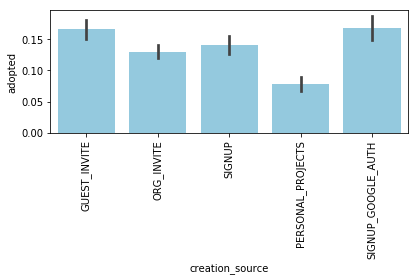

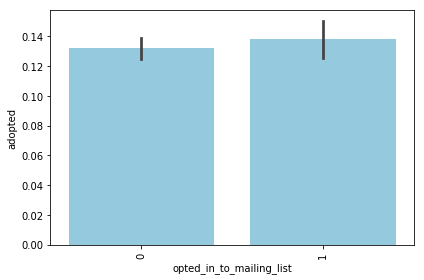

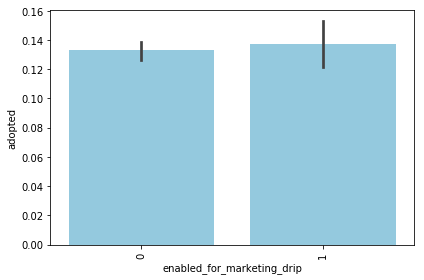

In [134]:
for col in categorical_cols:
    g = sns.barplot(x=col, y='adopted', data = df_users, color="skyblue")
    plt.xticks(rotation=90)
    plt.tight_layout() # need for savefig
    plt.savefig(col+".png",format="png", dpi=300)
    plt.show()

The above figures show creation_source might be a good predictor.

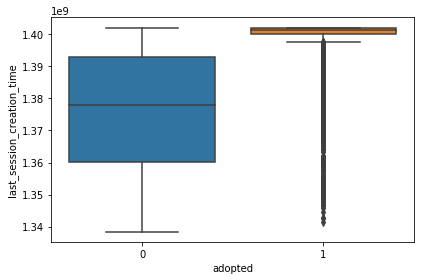

In [135]:
for col in numeric_cols:
    g = sns.boxplot(x='adopted', y=col, data = df_users)
    plt.tight_layout() # need for savefig
    plt.savefig(col+".png",format="png", dpi=300)    
    plt.show()

The column 'last_session_creation_time' has unix timestamps of last login for each user. The boxplot shows that a user is more liekly to be an adopted user if the user was logged in recently.

In [75]:
df_users.creation_time = pd.to_datetime(df_users.creation_time)

In [85]:
def draw_adopted_rate(window, time_interval): 
    ''' Draw login counts based on a given time interval and time window ''' 
    df_users[window][['creation_time','adopted']].set_index('creation_time').resample(time_interval).mean().plot(figsize=(18, 4)) 
    plt.xlabel('Creation times ('+time_interval+' intervals)') 
    plt.ylabel('Adopted user rate') 
    plt.show()

In [87]:
last_creation_time = df_users.creation_time.max()
first_creation_time = df_users.creation_time.min()
first_creation_time, last_creation_time

(Timestamp('2012-05-31 00:43:27'), Timestamp('2014-05-30 23:59:19'))

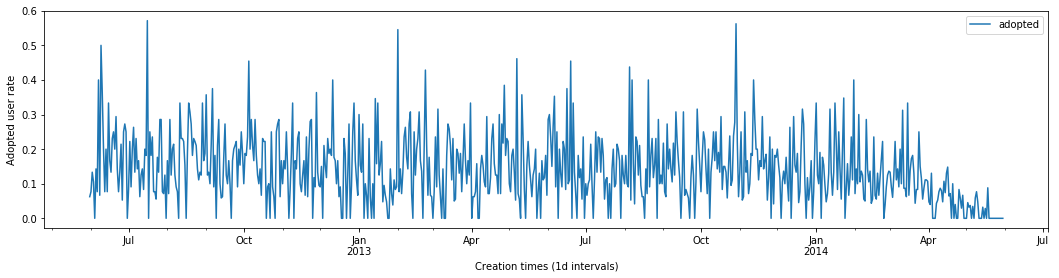

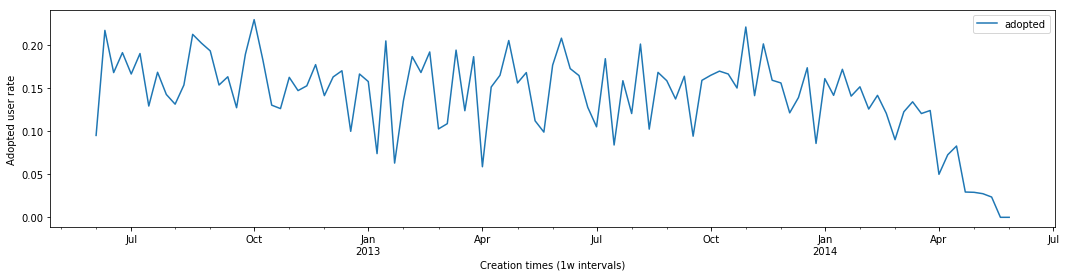

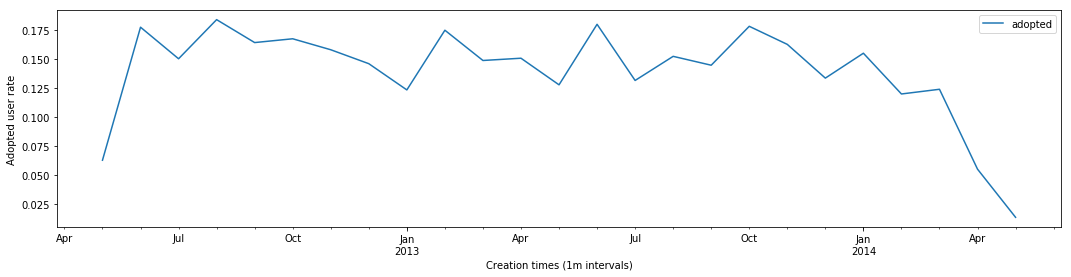

In [89]:
window = (df_users.creation_time <= last_creation_time)
for time_interval in ['1d','1w','1m']:
    draw_adopted_rate(window, time_interval)

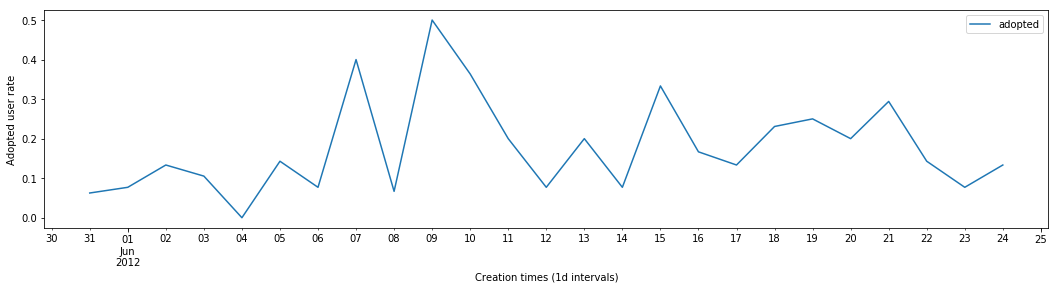

In [97]:
window = (df_users.creation_time <= first_creation_time + timedelta(days=25))
time_interval = '1d'
draw_adopted_rate(window, time_interval)

I found no pattern or cycle from creation_time. I will not use this datetime column in the prediction model.

#### Brief model buiding

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [99]:
df_users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adopted'],
      dtype='object')

I will keep the categorical columns 'org_id' and 'invited_by_user_id' as numeric predictors since there are too many possible values, which are too many for one-hot encoding. They might help predictions since I am not using a linear model.

In [101]:
df_ML = df_users.drop(['object_id', 'creation_time', 'name', 'email'], axis=1)
df_ML.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [102]:
df_ML = pd.get_dummies(df_ML, drop_first=True)
df_ML.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.398139e+09,1,0,11,10803.0,0,0,0,0,0
1,1.396238e+09,0,0,1,316.0,1,1,0,0,0
2,1.363735e+09,0,0,94,1525.0,0,1,0,0,0
3,1.369210e+09,0,0,1,5151.0,0,0,0,0,0
4,1.358850e+09,0,0,193,5240.0,0,0,0,0,0


In [108]:
y = df_ML.adopted.values
X = df_ML.drop('adopted', axis=1).values

In [109]:
# check the size of y and X
len(y), len(X), len(X[0])

(12000, 12000, 9)

In [110]:
sum(y)/len(y)

0.1335

There are about 13.35% adopted users. 

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, 
                                                    random_state=32)

In [112]:
# Check the ratio of positive cases for training and test sets
sum(y_train)/len(y_train), sum(y_test)/len(y_test)

(0.1340625, 0.13125)

The proportions of positive cases for training and test sets are about the same, so stratified shuffle split is unnecessary.

In [122]:
# Make a function that prints the tuned hyper-parameters and metrics
def print_results(clf, verbose=False):
    print("Best score and hyper-parameters on dev. set:")
    print("%0.4f for %r" %(clf.best_score_, clf.best_params_))
    print() 
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    dev_result={'means':means,'stds':stds,'params':params}
    if verbose:   
        print("Grid search scores on dev. set:")
        for mean, std, params in zip(means, stds, params):
            print("%0.4f (+/-%0.04f) for %r" % (mean, std * 2, params))
    score = clf.score(X_test, y_test)
    print("\nScore on test set: {:.4f}".format(score))
    return dev_result

In [120]:
# Make a function that draw a feature importance plot
def plot_feature_importances(model_name, importances, feature_names, num_features=None, 
                             fig_size=None, ax=None):
    features_importances = pd.DataFrame(sorted(zip(feature_names, importances), 
                                           key = lambda tup: tup[1], reverse=True),
                                   columns=['features','importances'])
    data = features_importances[:num_features]
    data.plot('features','importances', kind='barh', ax=ax,
              color='blue', figsize=fig_size, legend = None)
    plt.gca().invert_yaxis() # reverse the order of features
    plt.ylabel('feature importances')
    if num_features:
        plt.title(model_name + '\nTop '+str(num_features))
    else: 
        plt.title(model_name + '\nAll Features')
    
    return features_importances # return all importances

In [141]:
%%time
# with default hyperparameters
param_grid = {}
lgbm = lgb.LGBMClassifier(random_state =32) #boosting_type='gbdt' by default   
clf= GridSearchCV(lgbm, param_grid, scoring='average_precision', cv=3)
clf.fit(X_train, y_train)
dev_result = print_results(clf, True)

Best score and hyper-parameters on dev. set:
0.7052 for {}

Grid search scores on dev. set:
0.7052 (+/-0.0301) for {}

Score on test set: 0.7385
Wall time: 534 ms


Note than the scoring method [average_precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) is a metric that summarizes a precision-recall curve. I chose this metric since I did not want to use a metric that depends on one threshold (e.g., precision, recall, and f1). AUC (area under ROC curve) was another option, but AUC is not appropriate for data with rare positive cases (here 13.35%).

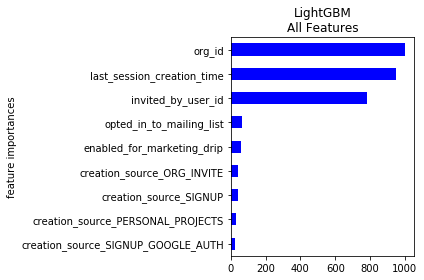

In [142]:
feature_col = df_ML.drop('adopted', axis=1).columns
importances = plot_feature_importances('LightGBM', clf.best_estimator_.feature_importances_, feature_col)
plt.tight_layout()
plt.savefig("feature_importances_baseline.png",format="png", dpi=300) 

In [143]:
importances

,features,importances
0,org_id,1003
1,last_session_creation_time,952
2,invited_by_user_id,785
3,opted_in_to_mailing_list,67
4,enabled_for_marketing_drip,61
5,creation_source_ORG_INVITE,41
6,creation_source_SIGNUP,40
7,creation_source_PERSONAL_PROJECTS,28
8,creation_source_SIGNUP_GOOGLE_AUTH,23


In [124]:
%%time
param_grid = {'max_depth':[2,5,10],
             'learning_rate':[.01,.05,.1],
             'n_estimators':[100,200,300],
             'subsample':[.5,.8,1.0],
             'subsample_freq':[0,15,30,50],
             'colsample_bytree':[.5,.8,1.0]}
lgbm = lgb.LGBMClassifier(random_state =32)   
clf= GridSearchCV(lgbm, param_grid, scoring='average_precision', cv=3)
clf.fit(X_train, y_train)
dev_result_1 = print_results(clf)

Best score and hyper-parameters on dev. set:
0.7272 for {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.8, 'subsample_freq': 30}


Score on test set: 0.7492
Wall time: 1min 54s


In [126]:
%%time
param_grid = {'max_depth':[2,5,10],
             'learning_rate':[.01,.05,.1],
             'n_estimators':[100,200,300],
             'subsample':[.5,.8,1.0],
             'subsample_freq':[0,15,30,50],
             'colsample_bytree':[.5,.8,1.0]}
lgbm = lgb.LGBMClassifier(random_state =32)   
clf= GridSearchCV(lgbm, param_grid, scoring='average_precision', cv=3)
clf.fit(X_train, y_train)
dev_result_1 = print_results(clf)

Best score and hyper-parameters on dev. set:
0.7300 for {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.5, 'subsample_freq': 15}


Score on test set: 0.7503
Wall time: 7min 43s


In [136]:
# Best model
param_grid = {'max_depth':[2],
             'learning_rate':[.01],
             'n_estimators':[200],
             'subsample':[.5],
             'subsample_freq':[15],
             'colsample_bytree':[.8]}
lgbm = lgb.LGBMClassifier(random_state =32)   
clf= GridSearchCV(lgbm, param_grid, scoring='average_precision', cv=3)
clf.fit(X_train, y_train)
dev_result_1 = print_results(clf)

Best score and hyper-parameters on dev. set:
0.7300 for {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.5, 'subsample_freq': 15}


Score on test set: 0.7503


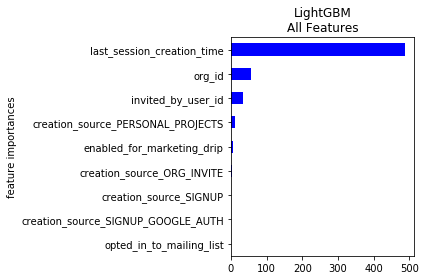

In [139]:
feature_col = df_ML.drop('adopted', axis=1).columns
importances = plot_feature_importances('LightGBM', clf.best_estimator_.feature_importances_, feature_col)
plt.tight_layout() # need for savefig
plt.savefig("feature_importances_best.png",format="png", dpi=300)  

In [140]:
importances

,features,importances
0,last_session_creation_time,489
1,org_id,56
2,invited_by_user_id,34
3,creation_source_PERSONAL_PROJECTS,12
4,enabled_for_marketing_drip,5
5,creation_source_ORG_INVITE,2
6,creation_source_SIGNUP,1
7,creation_source_SIGNUP_GOOGLE_AUTH,1
8,opted_in_to_mailing_list,0


All features I used had some importance in the prediction model if hyperparameters are not tuned. If they are tuned, the model is optimized with lower subsample proportion (subsample=.5), lower number of features (colsample_bytree=.8), and smaller max depth (max_depth=2) for each tree (these reduce overfitting!!). As a consequence, the less important features are ignored and had zero importances. 

Although __last_session_creation_time__ looks like a good predictor here, the feature is more like a consequence of user adoptions, not a factor of user adoption. In other words, adopted users are likely to have logged in recently just because they are adopted. Therefore, more useful factors I found here are 
- organization id of a user
- invited user id
- whether an account is created by invitation to join another user's  personal workspace or not  
- whether a user is on the marketing email drip or not.

If last_session_creation_time is removed, the model performance is actually very poor. Thus, I would recommend to collect better information about users to predict user adoptions. 